In [2]:
import numpy as np
import pandas as pd
import contextlib
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import io

import os
import sys
from joblib import dump,load
from tqdm import tqdm

from experiment_utils import *
home_dir = os.path.abspath("..")  # Move up to the home directory
sys.path.append(home_dir)
from comparator.DOPE.estimators import *
src_path = os.path.abspath("../src")
sys.path.append(src_path)
from models import *
from utils import *

# Suppress R console output
@contextlib.contextmanager
def suppress_r_output():
    r_output = io.StringIO()
    with contextlib.redirect_stdout(r_output), contextlib.redirect_stderr(r_output):
        yield
# Suppress R console output

with suppress_r_output():
    robjects.r['source'](r'../comparator/CollaborativeLearning/models.r')
    run_comparator = robjects.globalenv['run_comparator']

In [3]:
df=pd.read_pickle('../comparator/DOPE/NHANES_removed_original.pkl')
df.columns

Index(['high_pulse_pressure', 'sex_isFemale', 'age', 'physical_activity',
       'serum_albumin', 'alkaline_phosphatase_isUnacceptable',
       'alkaline_phosphatase_isTestnotdone', 'SGOT_isUnacceptable',
       'SGOT_isTestnotdone', 'BUN_isUnacceptable', 'BUN_isTestnotdone',
       'calcium_isUnacceptable', 'calcium_isTestnotdone',
       'creatinine_isUnacceptable', 'creatinine_isTestnotdone',
       'potassium_isUnacceptable', 'sodium_isUnacceptable',
       'total_bilirubin_isUnacceptable', 'total_bilirubin_isTestnotdone',
       'serum_protein', 'red_blood_cells', 'red_blood_cells_isUnacceptable',
       'red_blood_cells_isBlankbutapplicable', 'white_blood_cells',
       'white_blood_cells_isUnacceptable',
       'white_blood_cells_isBlankbutapplicable', 'hemoglobin',
       'hemoglobin_isMissing', 'hematocrit', 'hematocrit_isUnacceptable',
       'hematocrit_isMissing', 'platelets_isNormal', 'platelets_isIncreased',
       'platelets_isDecreased', 'platelets_isNoestimate', 'chole

In [3]:
df['age'].describe()

count    14264.000000
mean        48.905707
std         15.574155
min         25.000000
25%         35.000000
50%         48.000000
75%         65.000000
max         75.000000
Name: age, dtype: float64

<Axes: >

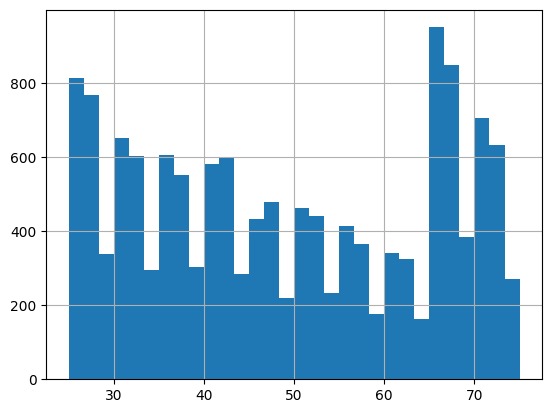

In [4]:
df['age'].hist(bins=30)

<Axes: >

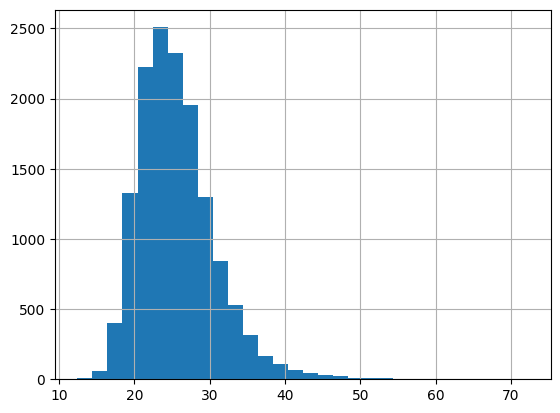

In [5]:
df['bmi'].hist(bins=30)

<Axes: >

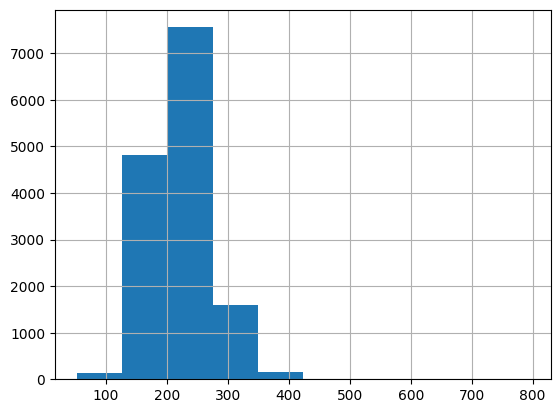

In [6]:
df['cholesterol'].hist()

In [7]:
df['high_pulse_pressure'].sum()

3121

<Axes: >

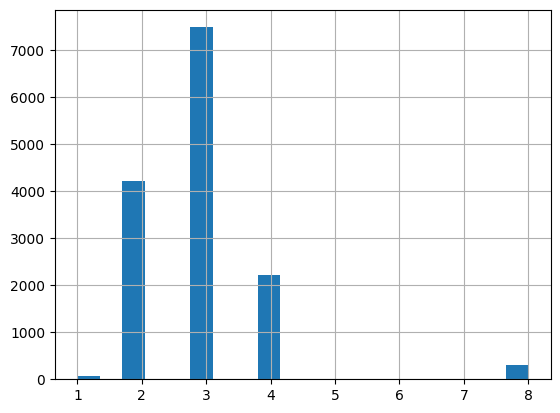

In [8]:
df['physical_activity'].hist(bins=20)

In [9]:
threshold = df['bmi'].quantile(0.9)
threshold

32.03696840638411

In [10]:
np.corrcoef(df['bmi'],df['cholesterol'])

array([[1.        , 0.14904512],
       [0.14904512, 1.        ]])

In [11]:

# # median_value = df['physical_activity'].median()
# # df['physical_activity_binary'] = (df['physical_activity'] > median_value).astype(int)
# import pandas as pd

# Assuming your DataFrame is named df and has a column 'physical_activity'
# threshold = df['physical_activity'].quantile(0.5)
# df['physical_activity_binary'] = (df['physical_activity'] >= threshold).astype(int)

df['bmi_binary'] = (df['bmi'] >= 30).astype(int)


In [12]:
# drop missing values of cholesterol
df=df[df['cholesterol_isMissing']==0]
# df=df[df['SGOT_isTestnotdone']==0]
# df=df[df['alkaline_phosphatase_isTestnotdone']==0]
# df=df[df['BUN_isTestnotdone']==0]
# df=df[df['creatinine_isTestnotdone']==0]
# df=df[df['total_bilirubin_isTestnotdone']==0]
# df=df[df['uric_acid_isTestnotdone']==0]
# df=df[df['platelets_isNoestimate']==0]
# df=df[df['hematocrit_isMissing']==0]
# df=df[df['hemoglobin_isMissing']==0]
# df=df[df['urine_hematest_isBlankbutapplicable']==0]
# df=df[df['sedimentation_rate_isBlankbutapplicable']==0]
# df=df[df['urine_albumin_isBlankbutapplicable']==0]
# df=df[df['white_blood_cells_isBlankbutapplicable']==0]
# df=df[df['red_blood_cells_isBlankbutapplicable']==0]
# df=df[df['urine_glucose_isBlankbutapplicable']==0]
# df=df[df['urine_pH_isBlankbutapplicable']==0]
# df=df[df['physical_activity']<8]
df=df[40<=df['age']]
df=df[df['age']<=65]
#df['physical_activity_binary'] = (df['physical_activity'] > 0).astype(int)

df=df.rename(columns={'cholesterol':'y', 'bmi_binary':'A'})
# df=df.rename(columns={'cholesterol':'y', 'high_pulse_pressure':'A'})
# df=df.rename(columns={'hemoglobin':'y', 'high_pulse_pressure':'A'})
# df=df.rename(columns={'bmi':'y', 'physical_activity_binary':'A'})

df.drop(['death',
        'cholesterol_isMissing',
        # 'SGOT_isTestnotdone',
        # 'alkaline_phosphatase_isTestnotdone',
        # 'BUN_isTestnotdone',
        # 'creatinine_isTestnotdone', 
        # 'high_pulse_pressure',
        # 'serum_albumin',
        # 'physical_activity',
        'bmi',
        # 'total_bilirubin_isTestnotdone',
        # 'platelets_isNoestimate', 
        # 'uric_acid_isTestnotdone',
        # 'hematocrit_isMissing',
        # 'hemoglobin_isMissing',
        # 'urine_hematest_isBlankbutapplicable',
        # 'sedimentation_rate_isBlankbutapplicable',
        # 'urine_albumin_isBlankbutapplicable',
        # 'white_blood_cells_isBlankbutapplicable',
        # 'red_blood_cells_isBlankbutapplicable',
        # 'urine_glucose_isBlankbutapplicable',
        #  'urine_pH_isBlankbutapplicable'
    ], axis=1, inplace=True)

# Suppose df is your DataFrame

# Create an empty dictionary to hold our mapping
rename_mapping = {}
counter = 1

# Loop through the current columns
for col in df.columns:
    # If the column is not 'A' or 'y', add it to the mapping
    if col not in ['A', 'y']:
        rename_mapping[col] = f"X{counter}"
        counter += 1

# Rename the columns in-place
df.rename(columns=rename_mapping, inplace=True)


In [13]:
df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X53,X54,X55,X56,X57,X58,X59,X60,X61,A
count,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,...,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000,5985.000000
mean,0.199332,0.564244,51.865163,2.954553,4.360850,0.035923,0.011696,0.032916,0.017544,0.006683,...,0.015205,0.009691,0.003342,0.041771,15.940978,0.068672,0.005848,0.012531,135.829741,0.185464
std,0.399531,0.495897,7.901552,0.944803,0.263131,0.186114,0.107522,0.178431,0.131297,0.081485,...,0.122376,0.097972,0.057715,0.200082,8.970286,0.252916,0.076254,0.111249,22.952147,0.388706
min,0.000000,0.000000,40.000000,1.000000,2.800000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,80.000000,0.000000
25%,0.000000,0.000000,45.000000,2.000000,4.300000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,120.000000,0.000000
50%,0.000000,1.000000,51.000000,3.000000,4.362309,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,16.125516,0.000000,0.000000,0.000000,132.000000,0.000000
75%,0.000000,1.000000,59.000000,3.000000,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,150.000000,0.000000
max,1.000000,1.000000,65.000000,8.000000,5.600000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,62.000000,1.000000,1.000000,1.000000,270.000000,1.000000


In [14]:
def estimation(p, df=None, ate=0, #placeholder
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='torch_nn',w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=True, mu_est=True, stds_return=True, coverage_return=False):

    random.seed(random_seed)

    pandas2ri.activate()

    with suppress_r_output():
        r_df = pandas2ri.py2rpy(df)

    if propen_est:
        ates, stds, df_est = single_trial(
            true_ate=ate, df_full=df, p=p,
            ps_model=ps_model, or_model=or_model,
            w_model=w_model,
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds, stds_return=True,coverage_return=False
        )
        with suppress_r_output():
            r_df = pandas2ri.py2rpy(df_est)
            r_result = run_comparator(df=r_df, p=p, propen_est=propen_est, mu_est=mu_est,random_seed=random_seed)
            result = dict(zip(r_result.names, list(r_result)))
    else:
        with suppress_r_output():
            r_result = run_comparator(df=r_df, p=p, propen_est=propen_est, mu_est=mu_est,random_seed=random_seed)
            result = dict(zip(r_result.names, list(r_result)))

        df['propen'] = result['pi_hat']
        df['mu0'] = result['r0_out']
        df['mu1'] = result['r1_out']

        # Run single trial with results
        ates, stds = single_trial(
            true_ate=ate, df_full=df, p=p,
            ps_model=ps_model, or_model=or_model,
            w_model=w_model,
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds, stds_return=True,coverage_return=False
        )

    # dope
    X_cols = [f"X{i}" for i in range(1, p + 1)]
    ates_dope, vars_dope = SI_IM_cf(T=df['A'].values,Y=df['y'].values, W=df[X_cols].values)

    all_ate = {'true_ate':ate,
                'ate_tmle':result['ate.tmle'][0],
                'ate_ctmle':result['ate.ctmle'][0],
                'ate_cbps':result['ate.cbps'][0],
                'ate_mr':ates['ate_mr'],
                'ate_ipw':ates['ate_ipw'],
                'ate_amr':ates['ate_amr'],
                'ate_aipw':ates['ate_aipw'],
                'ate_siaipw': ates_dope[1],
                'ate_sioapw': ates_dope[2],
                'ate_siobpw': ates_dope[3]}

    all_std = {
                'std_tmle':result['sd.tmle'][0],
                'std_ctmle':result['sd.ctmle'][0],
                'std_cbps':result['sd.cbps'][0],
                'std_mr':stds['ate_mr'],
                'std_ipw':stds['ate_ipw'],
                'std_amr':stds['ate_amr'],
                'std_aipw':stds['ate_aipw'],
                'std_siaipw':np.sqrt(vars_dope[1]),
                'std_sioapw':np.sqrt(vars_dope[2]),
                'std_siobpw': np.sqrt(vars_dope[3])
                }
    return all_ate, all_std, df_est

(array([0.24789135, 0.64833122, 1.56362236, 1.63989662, 2.8030791 ,
        3.54675315, 4.44297572, 5.05316981, 4.30949576, 4.55738711,
        5.12944407, 4.90062129, 5.39640399, 5.33919829, 4.61459281,
        4.55738711, 3.96626159, 3.94719302, 3.71837024, 3.26072467,
        3.10817615, 2.97469619, 2.61239345, 2.19288501, 2.57425632,
        2.21195358, 2.00219936, 1.75430801, 1.54455379, 1.44921096,
        1.33479957, 1.04877109, 0.70553692, 1.18225105, 1.35386814,
        0.95342827, 0.97249683, 0.97249683, 0.72460548, 0.51485126,
        0.64833122, 0.57205696, 0.438577  , 0.38137131, 0.36230274,
        0.26695991, 0.40043987, 0.438577  , 0.24789135, 0.41950844,
        0.24789135, 0.17161709, 0.36230274, 0.09534283, 0.17161709,
        0.20975422, 0.24789135, 0.15254852, 0.13347996, 0.17161709,
        0.09534283, 0.22882278, 0.13347996, 0.07627426, 0.07627426,
        0.15254852, 0.17161709, 0.15254852, 0.0572057 , 0.03813713,
        0.0572057 , 0.01906857, 0.0572057 , 0.03

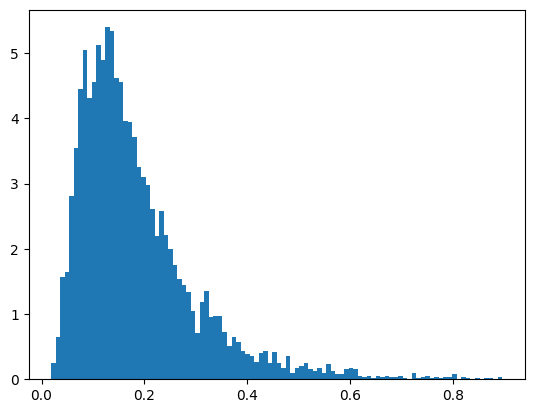

In [15]:
X_cols = [f"X{i}" for i in range(1, 61+ 1)]
ps_model = LogisticRegression()
ps_model.fit(df[X_cols].values, df['A'].values)
p_train = ps_model.predict_proba(df[X_cols].values)[:, 1]
plt.hist(p_train,density=True,bins=100)

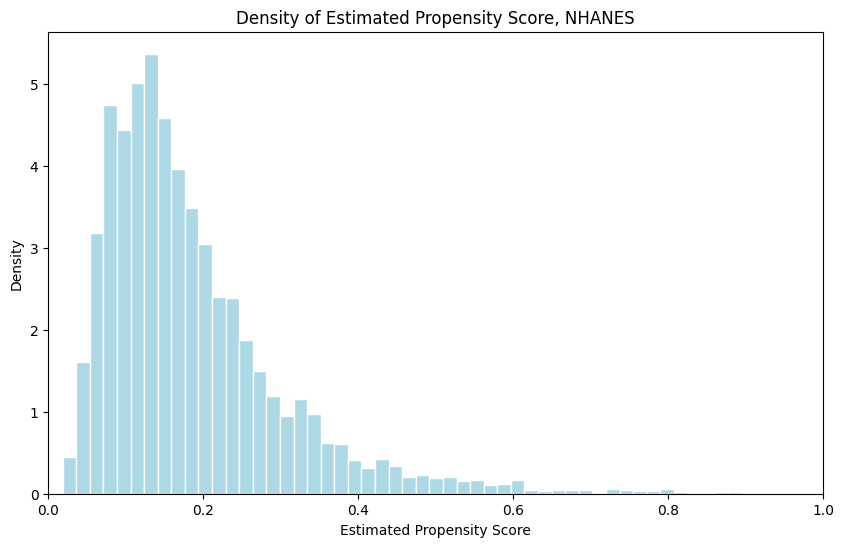

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Plot the histogram with a fancier color (e.g., lightblue) and add a white edge to each bin
plt.hist(p_train, bins=50, color='lightblue', edgecolor='white', density=True)

# Add the x and y labels
plt.xlabel('Estimated Propensity Score')
plt.ylabel('Density')

# Add a LaTeX-formatted title (you can also use 'coral' for a different color)
plt.title('Density of Estimated Propensity Score, NHANES')

# Set x-axis limits from 0 to 1
plt.xlim(0, 1)

# Display the plot
plt.show()


In [17]:
df['propen']=p_train

In [18]:
# sampled_df = df.sample(n=8000, replace=False,random_state=42)
# sampled_df = df.sample(n=5000, replace=False,random_state=42)
ate_results, std_results,df_est = estimation(p=61, df=df, ate=0, #placeholder
                          cross_fit=True, n_folds=5, ps_model='original',or_model='torch_nn',
                          w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=True, mu_est=True, stds_return=True, coverage_return=False)

# ate_output_file = "results/nhanes/ate_cholesterol_lr.joblib"
# std_output_file = "results/nhanes/std_cholesterol_lr.joblib"
# os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
# os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
# dump(ate_results, ate_output_file)
# print(f"Results saved to {ate_output_file}")
# dump(std_results, std_output_file)
# print(f"Results saved to {std_output_file}")
print('ate: ', ate_results)
print('std: ', std_results)

ate:  {'true_ate': 0, 'ate_tmle': 3.410591341069221, 'ate_ctmle': 2.585917952550699, 'ate_cbps': 4.701750453319766, 'ate_mr': 4.369658190618651, 'ate_ipw': 3.8994489878182974, 'ate_amr': 3.4361822682092775, 'ate_aipw': 3.420202428352406, 'ate_siaipw': 230.03241748221572, 'ate_sioapw': 229.8759549997013, 'ate_siobpw': 229.8739293253416}
std:  {'std_tmle': 1.7490423385661873, 'std_ctmle': 1.579939660959257, 'std_cbps': 2.181562080950062, 'std_mr': 9.185053902530791, 'std_ipw': 9.185051891220816, 'std_amr': 1.7473561200810674, 'std_aipw': 1.7473561078703308, 'std_siaipw': 220.18209447265764, 'std_sioapw': 115.652236627838, 'std_siobpw': 115.63574619230386}


In [20]:
2.5859-1.5799*1.96

-0.510704

In [19]:
# sampled_df = df.sample(n=8000, replace=False,random_state=42)
# sampled_df = df.sample(n=5000, replace=False,random_state=42)
ate_results, std_results,df_est = estimation(p=61, df=df, ate=0, #placeholder
                          cross_fit=True, n_folds=5, ps_model='original',or_model='lr',
                          w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=True, mu_est=True, stds_return=True, coverage_return=False)

# ate_output_file = "results/nhanes/ate_cholesterol_lr.joblib"
# std_output_file = "results/nhanes/std_cholesterol_lr.joblib"
# os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
# os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
# dump(ate_results, ate_output_file)
# print(f"Results saved to {ate_output_file}")
# dump(std_results, std_output_file)
# print(f"Results saved to {std_output_file}")
print('ate: ', ate_results)
print('std: ', std_results)

ate:  {'true_ate': 0, 'ate_tmle': 3.1516283907989475, 'ate_ctmle': 3.8997916698282187, 'ate_cbps': 4.701750453319766, 'ate_mr': 4.369658190618651, 'ate_ipw': 3.8994489878182974, 'ate_amr': 3.5622129570080103, 'ate_aipw': 3.1440033889535304, 'ate_siaipw': 229.79694288170015, 'ate_sioapw': 229.85193950115953, 'ate_siobpw': 229.85047439175028}
std:  {'std_tmle': 1.768828081156364, 'std_ctmle': 1.5738015769044262, 'std_cbps': 2.181562080950062, 'std_mr': 9.185053902530791, 'std_ipw': 9.185051891220816, 'std_amr': 1.7712203418985037, 'std_aipw': 1.771212091123031, 'std_siaipw': 223.0890700748985, 'std_sioapw': 114.07131718709299, 'std_siobpw': 114.05922133441848}


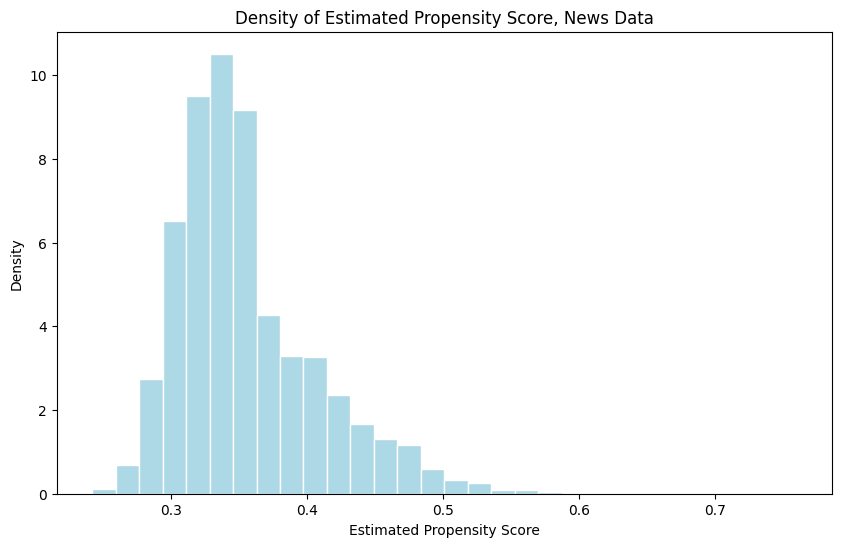

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot the histogram with a fancier color (e.g., lightblue) and add a black edge to each bin
plt.hist(df_est['hat_propen'], bins=30, color='lightblue', edgecolor='white', density = True)

# Add the x and y labels
plt.xlabel('Estimated Propensity Score')
plt.ylabel('Density')

# Add a LaTeX-formatted title (you can also use 'coral' for a different color)
plt.title('Density of Estimated Propensity Score, News Data')

# Display the plot
plt.show()

In [17]:
# sampled_df = df.sample(n=8000, replace=False,random_state=42)
sampled_df = df.sample(n=5000, replace=False,random_state=42)
ate_results, std_results,df_est = estimation(p=62, df=sampled_df, ate=0, #placeholder
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='torch_nn',
                          w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=True, mu_est=True, stds_return=True, coverage_return=False)

ate_output_file = "results/nhanes/ate_bmi_lr_5000.joblib"
std_output_file = "results/nhanes/std_bmi_lr_5000.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
print('ate: ', ate_results)
print('std: ', std_results)

Results saved to results/nhanes/ate_bmi_lr_5000.joblib
Results saved to results/nhanes/std_bmi_lr_5000.joblib
ate:  {'true_ate': 0, 'ate_tmle': 0.010115179080809326, 'ate_ctmle': -0.00034120528394776826, 'ate_cbps': -0.0020300010280613497, 'ate_mr': -0.0024693971219731372, 'ate_ipw': -0.002222246911950674, 'ate_amr': -0.00021734129650706322, 'ate_aipw': 0.01304293084368127, 'ate_siaipw': 0.0003185157948277139, 'ate_sioapw': 0.0011420082334251862, 'ate_siobpw': 0.00042376858773825334}
std:  {'std_tmle': 0.009370277426114477, 'std_ctmle': 0.006419858861126274, 'std_cbps': 0.008571739762232553, 'std_mr': 0.008050839697253601, 'std_ipw': 0.008050838938383086, 'std_amr': 0.010180315056381605, 'std_aipw': 0.010178587360186299, 'std_siaipw': 0.6706907808854232, 'std_sioapw': 0.441051378566244, 'std_siobpw': 0.45541523222288577}


In [16]:
# sampled_df = df.sample(n=8000, replace=False,random_state=42)
sampled_df = df.sample(n=5000, replace=False,random_state=42)
ate_results, std_results,df_est = estimation(p=62, df=df, ate=0, #placeholder
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='torch_nn',
                          w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=True, mu_est=True, stds_return=True, coverage_return=False)

ate_output_file = "results/nhanes/ate_bmi_lr.joblib"
std_output_file = "results/nhanes/std_bmi_lr.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
print('ate: ', ate_results)
print('std: ', std_results)

Results saved to results/nhanes/ate_bmi_lr.joblib
Results saved to results/nhanes/std_bmi_lr.joblib
ate:  {'true_ate': 0, 'ate_tmle': 0.0037218725102642217, 'ate_ctmle': 0.005599520253479686, 'ate_cbps': 0.00465745899757056, 'ate_mr': 0.0012978344127427426, 'ate_ipw': 0.002518636669344157, 'ate_amr': 0.006566639765068744, 'ate_aipw': 0.003576774683710785, 'ate_siaipw': 0.007207850852827924, 'ate_sioapw': 0.00534964569572897, 'ate_siobpw': 0.0047404352008982445}
std:  {'std_tmle': 0.004748660340792959, 'std_ctmle': 0.0038322728900182816, 'std_cbps': 1.997387672503704, 'std_mr': 0.004438409361372941, 'std_ipw': 0.004438397590111936, 'std_amr': 0.0047857780289706775, 'std_aipw': 0.004785712548359552, 'std_siaipw': 0.507122292891237, 'std_sioapw': 0.4314354479793403, 'std_siobpw': 0.44653530996558594}


In [18]:
# sampled_df = df.sample(n=8000, replace=False,random_state=42)
sampled_df = df.sample(n=5000, replace=False,random_state=42)
ate_results, std_results,df_est = estimation(p=62, df=sampled_df, ate=0, #placeholder
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',
                          w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=True, mu_est=True, stds_return=True, coverage_return=False)

ate_output_file = "results/nhanes/ate_bmi_nn_5000.joblib"
std_output_file = "results/nhanes/std_bmi_nn_5000.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
print('ate: ', ate_results)
print('std: ', std_results)

Results saved to results/nhanes/ate_bmi_nn_5000.joblib
Results saved to results/nhanes/std_bmi_nn_5000.joblib
ate:  {'true_ate': 0, 'ate_tmle': 0.05852249014263403, 'ate_ctmle': -0.00034120528394776826, 'ate_cbps': -0.0020300010280613497, 'ate_mr': -0.003414940807441921, 'ate_ipw': 0.1278494972654901, 'ate_amr': -0.0036471582401225093, 'ate_aipw': 0.11027748120492277, 'ate_siaipw': 0.0003185157948277139, 'ate_sioapw': 0.0011420082334251862, 'ate_siobpw': 0.00042376858773825334}
std:  {'std_tmle': 0.028044623453560874, 'std_ctmle': 0.006419858861126274, 'std_cbps': 0.008571739762232553, 'std_mr': 0.05072404825770206, 'std_ipw': 0.05069006127198095, 'std_amr': 0.10523728784646616, 'std_aipw': 0.10522495174305681, 'std_siaipw': 0.6706907808854232, 'std_sioapw': 0.441051378566244, 'std_siobpw': 0.45541523222288577}


In [17]:
# sampled_df = df.sample(n=8000, replace=False,random_state=42)
sampled_df = df.sample(n=5000, replace=False,random_state=42)
ate_results, std_results,df_est = estimation(p=62, df=df, ate=0, #placeholder
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='rf',
                          w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=True, mu_est=True, stds_return=True, coverage_return=False)

ate_output_file = "results/nhanes/ate_bmi_rf.joblib"
std_output_file = "results/nhanes/std_bmi_rf.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
print('ate: ', ate_results)
print('std: ', std_results)

Results saved to results/nhanes/ate_bmi_rf.joblib
Results saved to results/nhanes/std_bmi_rf.joblib
ate:  {'true_ate': 0, 'ate_tmle': 0.006221108059653869, 'ate_ctmle': 0.005599520253479686, 'ate_cbps': 0.00465745899757056, 'ate_mr': 0.0012978344127427426, 'ate_ipw': 0.002518636669344157, 'ate_amr': 0.012740458417697676, 'ate_aipw': 0.006267492280971145, 'ate_siaipw': 0.0076215819607599435, 'ate_sioapw': 0.0043533587186969265, 'ate_siobpw': 0.0032774182566774755}
std:  {'std_tmle': 0.004083953594194095, 'std_ctmle': 0.0038322728900182816, 'std_cbps': 1.997387672503704, 'std_mr': 0.004438409361372941, 'std_ipw': 0.004438397590111936, 'std_amr': 0.004085496064819002, 'std_aipw': 0.00408513653070389, 'std_siaipw': 0.5068359204588361, 'std_sioapw': 0.4264316519064298, 'std_siobpw': 0.4494696532240491}


In [ ]:
# sampled_df = df.sample(n=8000, replace=False,random_state=42)

ate_results, std_results,df_est = estimation(p=52, df=df, ate=0, #placeholder
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',
                          w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=True, mu_est=True, stds_return=True, coverage_return=False)

ate_output_file = "results/nhanes/ate_bmi_nn.joblib"
std_output_file = "results/nhanes/std_bmi_nn.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
print('ate: ', ate_results)                 
print('std: ', std_results)

Results saved to results/nhanes/ate_bmi_nn.joblib
Results saved to results/nhanes/std_bmi_nn.joblib
ate:  {'true_ate': 0, 'ate_tmle': -0.04855748276482778, 'ate_ctmle': 0.0062321197862727, 'ate_cbps': 0.007428022625436189, 'ate_mr': 0.004499103526017387, 'ate_ipw': 0.023124974867759777, 'ate_amr': 0.007913763226928213, 'ate_aipw': -0.09638632232019816, 'ate_siaipw': 0.008826414632555239, 'ate_sioapw': 0.005180263256863319, 'ate_siobpw': 0.003409013084137638}
std:  {'std_tmle': 0.01545842462973984, 'std_ctmle': 0.003914007362444813, 'std_cbps': 0.005338522470176181, 'std_mr': 0.014797064518779369, 'std_ipw': 0.014796220102295286, 'std_amr': 0.05507043845300308, 'std_aipw': 0.05506332360656406, 'std_siaipw': 0.5214958202397713, 'std_sioapw': 0.4334308232449892, 'std_siobpw': 0.4623418339735471}


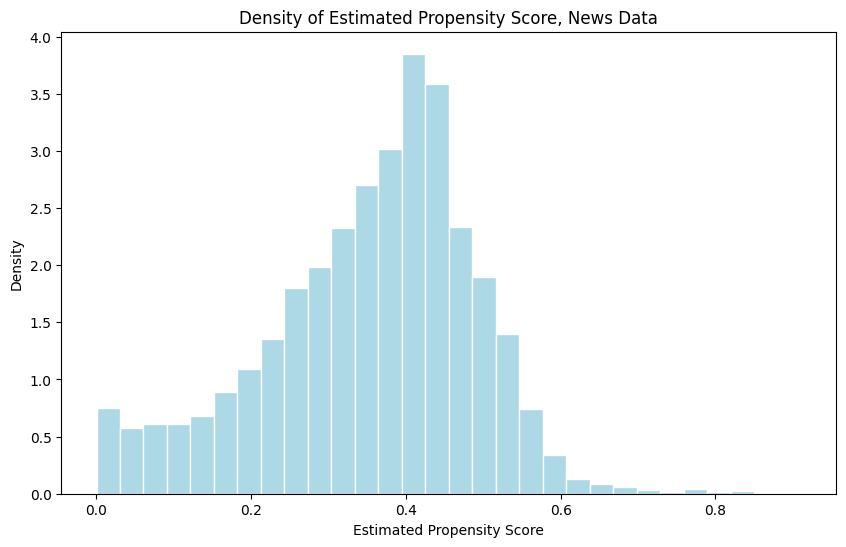

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot the histogram with a fancier color (e.g., lightblue) and add a black edge to each bin
plt.hist(df_est['hat_propen'], bins=30, color='lightblue', edgecolor='white', density = True)

# Add the x and y labels
plt.xlabel('Estimated Propensity Score')
plt.ylabel('Density')

# Add a LaTeX-formatted title (you can also use 'coral' for a different color)
plt.title('Density of Estimated Propensity Score, News Data')

# Display the plot
plt.show()


In [13]:

# ate_results, std_results,df_est = estimation(p=54, df=df, ate=0, #placeholder
#                           cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',
#                           w_model='kernel_ridge_regression', 
#                             random_seed=42, propen_est=True, mu_est=True, stds_return=True, coverage_return=False)

# ate_output_file = "results/nhanes/ate_serum.joblib"
# std_output_file = "results/nhanes/std_serum.joblib"
# os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
# os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
# dump(ate_results, ate_output_file)
# print(f"Results saved to {ate_output_file}")
# dump(std_results, std_output_file)
# print(f"Results saved to {std_output_file}")

In [11]:

ate_results, std_results,df_est = estimation(p=50, df=df, ate=0, #placeholder
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',
                          w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=True, mu_est=True, stds_return=True, coverage_return=False)

In [23]:
import pandas as pd

ates=  {'true_ate': 0, 'ate_tmle': 3.1516283907989475, 'ate_ctmle': 3.8997916698282187, 'ate_cbps': 4.701750453319766, 'ate_mr': 4.369658190618651, 'ate_ipw': 3.8994489878182974, 'ate_amr': 3.5622129570080103, 'ate_aipw': 3.1440033889535304, 'ate_siaipw': 229.79694288170015, 'ate_sioapw': 229.85193950115953, 'ate_siobpw': 229.85047439175028}
stds= {'std_tmle': 1.768828081156364, 'std_ctmle': 1.5738015769044262, 'std_cbps': 2.181562080950062, 'std_mr': 9.185053902530791, 'std_ipw': 9.185051891220816, 'std_amr': 1.7712203418985037, 'std_aipw': 1.771212091123031, 'std_siaipw': 223.0890700748985, 'std_sioapw': 114.07131718709299, 'std_siobpw': 114.05922133441848}
methods_to_use = ['ate_tmle', 'ate_ctmle', 'ate_cbps', 'ate_aipw','ate_siaipw', 'ate_mr','ate_ipw','ate_amr']

# Build a dictionary where each key is the display name and the value is a list:
# [point estimate, 95% confidence interval as a formatted string].
table_data = {}
for method in methods_to_use:
    est = ates[method]
    # Get the corresponding standard error.
    std_key = method.replace("ate_", "std_")
    std_val = stds[std_key]
    # Compute the 95% CI.
    lower = est - 1.96 * std_val
    upper = est + 1.96 * std_val
    # Format using four decimal places.
    ci_str = f"[{lower:.4f}, {upper:.4f}]"
    # Rename 'ate_siaipw' to DOPE.
    disp_name = "DOPE" if method == "ate_siaipw" else method.replace("ate_", "").upper()
    table_data[disp_name] = [f"{est:.4f}", ci_str]

# Create a DataFrame with two rows: Estimation and 95% CI.
df = pd.DataFrame(table_data, index=["Estimation", "95% CI"])

# Convert the DataFrame to a LaTeX table inside a table environment.
latex_table = (
    "\\begin{table}[ht]\n"
    "\\centering\n"
    "\\resizebox{\\textwidth}{!}{%\n" +
    df.to_latex(multicolumn=True, multirow=True, escape=False) +
    "\n}\n"
    "\\caption{ATE Estimates and 95\\% Confidence Intervals}\n"
    "\\end{table}"
)

print(latex_table)


\begin{table}[ht]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{lllllllll}
\toprule
 & TMLE & CTMLE & CBPS & AIPW & DOPE & MR & IPW & AMR \\
\midrule
Estimation & 3.1516 & 3.8998 & 4.7018 & 3.1440 & 229.7969 & 4.3697 & 3.8994 & 3.5622 \\
95% CI & [-0.3153, 6.6185] & [0.8151, 6.9844] & [0.4259, 8.9776] & [-0.3276, 6.6156] & [-207.4576, 667.0515] & [-13.6330, 22.3724] & [-14.1033, 21.9022] & [0.0906, 7.0338] \\
\bottomrule
\end{tabular}

}
\caption{ATE Estimates and 95\% Confidence Intervals}
\end{table}


# balancing score investigation

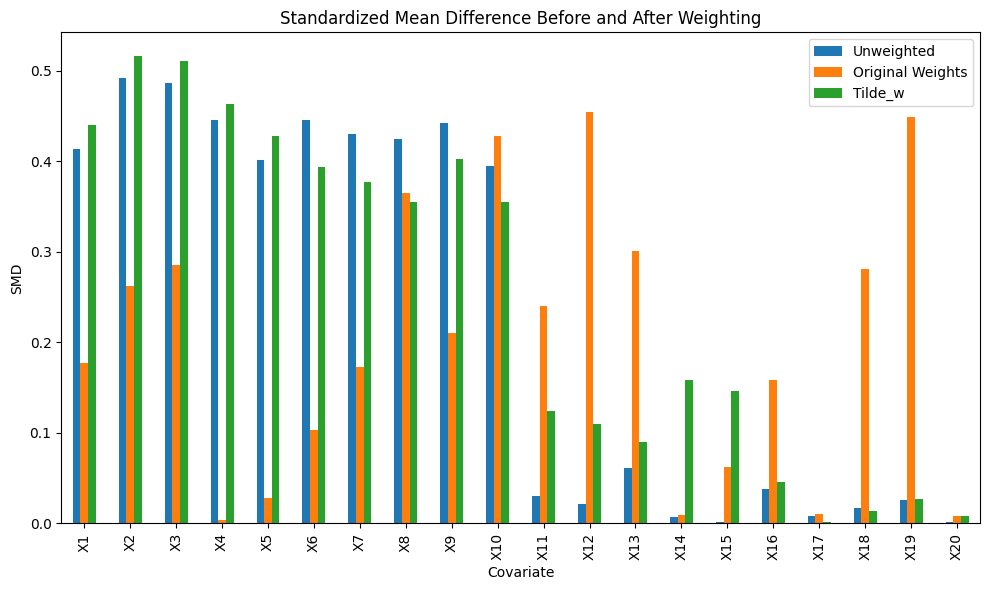

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = generate_data_causl(n=5000, nI=5, nX=5, nO=5, nS=5, 
                                        ate=0, beta_cov=0, strength_instr=1, strength_conf=1, strength_outcome=2)
p=20
X = df[[f'X{i+1}' for i in range(p)]]  # Your covariates, divided into types
A = df['A']
ates, stds, df_est = single_trial(
            true_ate=5, df_full=df, p=p,
            ps_model='original', or_model='lr',
            w_model='kernel_ridge_regression',
            random_seed=42, cross_fit=True, n_folds=5, stds_return=True,coverage_return=False
        )


pi = df['hat_propen']  # Assumed available

# Calculate original weights (with correct handling for control group)
original_weights = np.where(A == 1, (A - pi) / (pi * (1 - pi)), -((A - pi) / (pi * (1 - pi))))

# Assuming tilde_w is available
tilde_w = df['hat_tilde_w']
# tilde_w = np.where(A == 1, tilde_w, -tilde_w)
# Define a function to compute weighted variance.
def weighted_variance(x, w):
    """
    Compute the weighted variance of an array x with weights w.
    """
    avg = np.average(x, weights=w)
    return np.average((x - avg)**2, weights=w)

# Define a function to compute the SMD.
def compute_smd(treated, control, weights_treated=None, weights_control=None, use_weighted_var=True):
    """
    Compute the Standardized Mean Difference (SMD) between two groups.
    
    Parameters:
      treated: array-like, covariate values for the treated group.
      control: array-like, covariate values for the control group.
      weights_treated: array-like, weights for the treated group (default: None).
      weights_control: array-like, weights for the control group (default: None).
      use_weighted_var: bool, if True then compute weighted variances if weights are given.
    
    Returns:
      The absolute standardized mean difference.
    """
    # Compute means (weighted if weights are given)
    if weights_treated is not None:
        treated_mean = np.average(treated, weights=weights_treated)
        var_treated = weighted_variance(treated, weights_treated) if use_weighted_var else np.var(treated, ddof=1)
    else:
        treated_mean = np.mean(treated)
        var_treated = np.var(treated, ddof=1)
    
    if weights_control is not None:
        control_mean = np.average(control, weights=weights_control)
        var_control = weighted_variance(control, weights_control) if use_weighted_var else np.var(control, ddof=1)
    else:
        control_mean = np.mean(control)
        var_control = np.var(control, ddof=1)
    
    # Compute the pooled variance and return the SMD.
    pooled_var = (var_treated + var_control) / 2
    return abs(treated_mean - control_mean) / np.sqrt(pooled_var)



# Split treatment and control groups.
treated = df[df['A'] == 1]
control = df[df['A'] == 0]

# If your DataFrame X has its own index (say, after subsetting or reordering),
# convert the DataFrame indices (labels) to positional indices.
treated_pos = X.index.get_indexer(treated.index)
control_pos = X.index.get_indexer(control.index)

# Initialize a dictionary to hold SMD results for each covariate.
smd_results = {}
for covariate in X.columns:
    smd_results[covariate] = {
        'unweighted': compute_smd(treated[covariate], control[covariate]),
        'original_weights': compute_smd(
            treated[covariate],
            control[covariate],
            weights_treated=original_weights[treated_pos],
            weights_control=original_weights[control_pos]
        ),
        'tilde_w': compute_smd(
            treated[covariate],
            control[covariate],
            # Here we use the weights stored in df['hat_w1'] for treated and df['hat_w0'] for control.
            # Note: We use .iloc to select by integer positions.
            weights_treated=df['hat_w1'].iloc[treated_pos],
            weights_control=df['hat_w0'].iloc[control_pos]
        )
    }

# Convert the results into a DataFrame so that they can be easily viewed or plotted.
smd_df = pd.DataFrame(smd_results).T

# ----- Plot the SMDs -----
smd_df.plot(kind='bar', figsize=(10, 6))
plt.title('Standardized Mean Difference Before and After Weighting')
plt.xlabel('Covariate')
plt.ylabel('SMD')
plt.legend(['Unweighted', 'Original Weights', 'Tilde_w'])
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = sim_data_causl_non_linear(n=50000, nI=5, nX=5, nO=5, nS=5, 
                                        ate=5, beta_cov=0, strength_instr=1, strength_conf=0.5, strength_outcome=20)
p=20
X = df[[f'X{i+1}' for i in range(p)]]  # Your covariates, divided into types
A = df['A']
ates, stds, df_est = single_trial(
            true_ate=5, df_full=df, p=p,
            ps_model='original', or_model='torch_nn',
            w_model='kernel_ridge_regression',
            random_seed=42, cross_fit=True, n_folds=5, stds_return=True,coverage_return=False
        )


pi = df['hat_propen']  # Assumed available

# Calculate original weights (with correct handling for control group)
original_weights = np.where(A == 1, (A - pi) / (pi * (1 - pi)), -((A - pi) / (pi * (1 - pi))))

# Assuming tilde_w is available
tilde_w = df['hat_tilde_w']
# tilde_w = np.where(A == 1, tilde_w, -tilde_w)
# Define a function to compute weighted variance.
def weighted_variance(x, w):
    """
    Compute the weighted variance of an array x with weights w.
    """
    avg = np.average(x, weights=w)
    return np.average((x - avg)**2, weights=w)

# Define a function to compute the SMD.
def compute_smd(treated, control, weights_treated=None, weights_control=None, use_weighted_var=True):
    """
    Compute the Standardized Mean Difference (SMD) between two groups.
    
    Parameters:
      treated: array-like, covariate values for the treated group.
      control: array-like, covariate values for the control group.
      weights_treated: array-like, weights for the treated group (default: None).
      weights_control: array-like, weights for the control group (default: None).
      use_weighted_var: bool, if True then compute weighted variances if weights are given.
    
    Returns:
      The absolute standardized mean difference.
    """
    # Compute means (weighted if weights are given)
    if weights_treated is not None:
        treated_mean = np.average(treated, weights=weights_treated)
        var_treated = weighted_variance(treated, weights_treated) if use_weighted_var else np.var(treated, ddof=1)
    else:
        treated_mean = np.mean(treated)
        var_treated = np.var(treated, ddof=1)
    
    if weights_control is not None:
        control_mean = np.average(control, weights=weights_control)
        var_control = weighted_variance(control, weights_control) if use_weighted_var else np.var(control, ddof=1)
    else:
        control_mean = np.mean(control)
        var_control = np.var(control, ddof=1)
    
    # Compute the pooled variance and return the SMD.
    # pooled_var = (var_treated + var_control) / 2
    pooled_var = 1
    return abs(treated_mean - control_mean) / np.sqrt(pooled_var)



# Split treatment and control groups.
treated = df[df['A'] == 1]
control = df[df['A'] == 0]

# If your DataFrame X has its own index (say, after subsetting or reordering),
# convert the DataFrame indices (labels) to positional indices.
treated_pos = X.index.get_indexer(treated.index)
control_pos = X.index.get_indexer(control.index)

# Initialize a dictionary to hold SMD results for each covariate.
smd_results = {}
for covariate in X.columns:
    smd_results[covariate] = {
        'unweighted': compute_smd(treated[covariate], control[covariate]),
        'original_weights': compute_smd(
            treated[covariate],
            control[covariate],
            weights_treated=original_weights[treated_pos],
            weights_control=original_weights[control_pos]
        ),
        'tilde_w': compute_smd(
            treated[covariate],
            control[covariate],
            # Here we use the weights stored in df['hat_w1'] for treated and df['hat_w0'] for control.
            # Note: We use .iloc to select by integer positions.
            weights_treated=df['hat_w1'].iloc[treated_pos],
            weights_control=df['hat_w0'].iloc[control_pos]
        )
    }

# Convert the results into a DataFrame so that they can be easily viewed or plotted.
smd_df = pd.DataFrame(smd_results).T

# ----- Plot the SMDs -----
smd_df.plot(kind='bar', figsize=(10, 6))
plt.title('Standardized Mean Difference Before and After Weighting')
plt.xlabel('Covariate')
plt.ylabel('SMD')
plt.legend(['Unweighted', 'Original Weights', 'Tilde_w'])
plt.tight_layout()
plt.show()



100%|██████████| 1/1 [07:31<00:00, 451.61s/it]


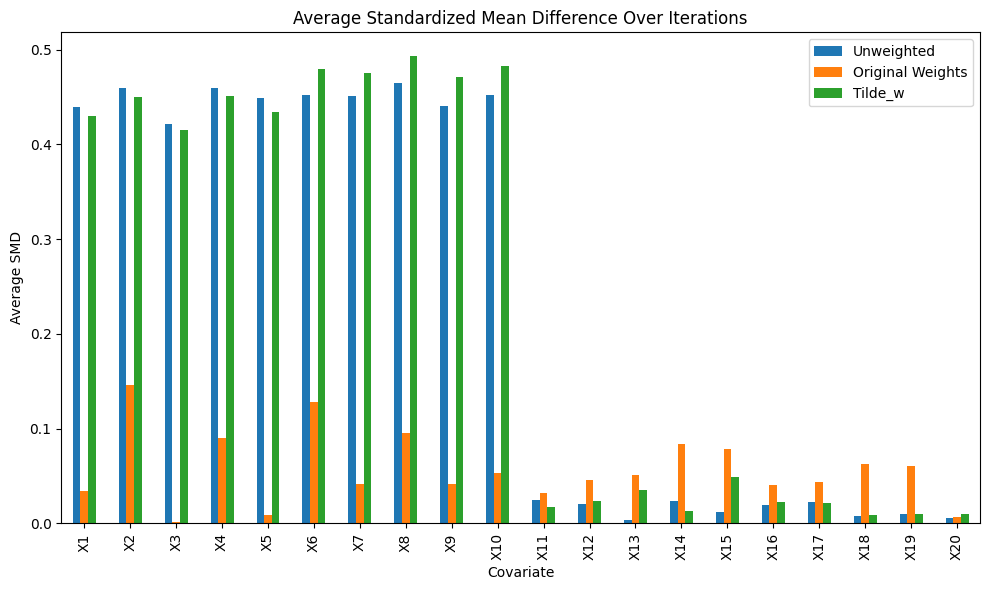

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Define helper functions ---
def weighted_variance(x, w):
    """
    Compute the weighted variance of an array x with weights w.
    """
    avg = np.average(x, weights=w)
    return np.average((x - avg)**2, weights=w)
def compute_smd(treated, control, weights_treated=None, weights_control=None):
    """
    Compute the Standardized Mean Difference (SMD) between two groups.
    
    Parameters:
      treated: array-like, covariate values for the treated group.
      control: array-like, covariate values for the control group.
      weights_treated: array-like, weights for the treated group (default: None).
      weights_control: array-like, weights for the control group (default: None).
    
    Returns:
      The absolute standardized mean difference.
    """
    # Compute weighted means if weights are provided, otherwise simple mean.
    if weights_treated is not None:
        treated_mean = np.average(treated, weights=weights_treated)
    else:
        treated_mean = np.mean(treated)
    
    if weights_control is not None:
        control_mean = np.average(control, weights=weights_control)
    else:
        control_mean = np.mean(control)
    
    # # # Compute variances: weighted variance if weights are provided, unweighted otherwise.
    # if weights_treated is not None:
    #     treated_var = np.average((treated - treated_mean)**2, weights=weights_treated)
    # else:
    #     treated_var = np.var(treated, ddof=1)
        
    # # if weights_control is not None:
    # #     control_var = np.average((control - control_mean)**2, weights=weights_control)
    # # else:
    # control_var = np.var(control, ddof=1)
    
    # # Calculate the pooled variance
    # pooled_var = (treated_var + control_var) / 2.0
    # pooled_var=1
    # Compute and return the absolute SMD
    smd = abs(treated_mean - control_mean) / np.sqrt(pooled_var)
    return smd
# def compute_smd(treated, control, weights_treated=None, weights_control=None):
#     """
#     Compute the Standardized Mean Difference (SMD) between two groups.
    
#     Parameters:
#       treated: array-like, covariate values for the treated group.
#       control: array-like, covariate values for the control group.
#       weights_treated: array-like, weights for the treated group (default: None).
#       weights_control: array-like, weights for the control group (default: None).
    
#     Returns:
#       The absolute standardized mean difference.
#     """
#     # Compute means (weighted if weights are provided)
#     if weights_treated is not None:
#         treated_mean = np.average(treated, weights=weights_treated)
#     else:
#         treated_mean = np.mean(treated)
    
#     if weights_control is not None:
#         control_mean = np.average(control, weights=weights_control)
#     else:
#         control_mean = np.mean(control)
    
#     # Compute variances using the original (unweighted) covariate values
#     var_treated = np.var(treated, ddof=1)
#     var_control = np.var(control, ddof=1)
    
#     # Pooled variance and SMD calculation
#     pooled_var = (var_treated + var_control) / 2
#     return abs(treated_mean - control_mean) / np.sqrt(pooled_var)


# --- Set simulation parameters ---
n_iterations = 1   # number of iterations (change as desired)
n = 10000             # sample size for each simulation
p = 20               # total number of covariates (assumed to be named X1, X2, ..., X20)
true_ate = 5         # true average treatment effect (ATE)

# --- Prepare a list to store the SMD DataFrame from each iteration ---
smd_list = []

# --- Loop over iterations ---
for seed in tqdm(range(n_iterations)):
    # Set the random seed so that each iteration uses a different seed.
    np.random.seed(seed)
    
    # Generate the simulated data (make sure your simulation function uses np.random)
    df = generate_data_causl(n=n, nI=5, nX=5, nO=5, nS=5, 
                                        ate=true_ate, beta_cov=0, strength_instr=1, strength_conf=1, strength_outcome=1)
    
    # Extract the covariate columns (assumes they are named X1, X2, ..., X20)
    X = df[[f'X{i+1}' for i in range(p)]]
    A = df['A']
    
    # Run your estimation/trial function.
    # (If you wish the estimation procedure to also vary with seed, you might consider replacing 42 with `seed`.)
    ates, stds, df_est = single_trial(
        true_ate=true_ate, df_full=df, p=p,
        ps_model='original', or_model='original',
        w_model='kernel_ridge_regression',
        random_seed=42, cross_fit=True, n_folds=3,
        stds_return=True, coverage_return=False
    )
    
    # --- Compute weights ---
    # Original weights (computed as in your code)
    pi = df['hat_propen']  # assumed to exist in df
    original_weights = np.where(A == 1, 1 / pi, 1 /  (1 - pi))
    
    # Assume tilde_w is available (uncomment the next line if you need to process it)
    tilde_w = df['hat_tilde_w']
    
    # --- Split data into treated and control groups ---
    treated = df[df['A'] == 1]
    control = df[df['A'] == 0]
    
    # Get positional indices so that we can match weights to the rows in X.
    treated_pos = X.index.get_indexer(treated.index)
    control_pos = X.index.get_indexer(control.index)
    
    # --- Compute SMDs for each covariate for each weighting method ---
    smd_iter = {}
    for covariate in X.columns:
        smd_iter[covariate] = {
            'unweighted': compute_smd(treated[covariate], control[covariate]),
            'original_weights': compute_smd(
                treated[covariate],
                control[covariate],
                weights_treated=original_weights[treated_pos],
                weights_control=original_weights[control_pos]
            ),
            'tilde_w': compute_smd(
                treated[covariate],
                control[covariate],
                # Here we use the weights stored in df['hat_w1'] for the treated group and df['hat_w0'] for the control group.
                weights_treated=df['hat_w1'].iloc[treated_pos],
                weights_control=(df['hat_w0']).iloc[control_pos]
                # weights_treated=np.abs(df['hat_tilde_w'].iloc[treated_pos]),
                # weights_control=np.abs(df['hat_tilde_w'].iloc[control_pos])
            )
        }
    
    # Convert the dictionary for this iteration into a DataFrame (rows: covariates; columns: weighting methods)
    smd_df_iter = pd.DataFrame(smd_iter).T
    smd_list.append(smd_df_iter)

# --- Compute the average SMD over iterations ---
# This adds up all the DataFrames and divides by the number of iterations.
smd_avg = sum(smd_list) / len(smd_list)

# --- Plot the average SMD ---
ax = smd_avg.plot(kind='bar', figsize=(10, 6),)
plt.title('Average Standardized Mean Difference Over Iterations')
plt.xlabel('Covariate')
plt.ylabel('Average SMD')
plt.legend(['Unweighted', 'Original Weights', 'Tilde_w'])
plt.tight_layout()
plt.show()


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


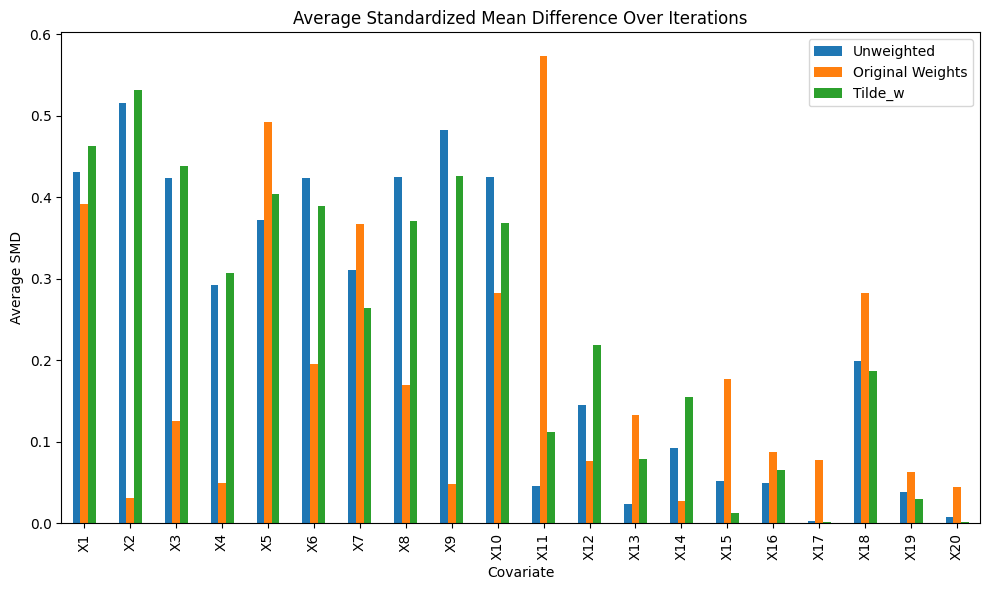

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Define helper functions ---
def weighted_variance(x, w):
    """
    Compute the weighted variance of an array x with weights w.
    """
    avg = np.average(x, weights=w)
    return np.average((x - avg)**2, weights=w)
def compute_smd(treated, control, weights_treated=None, weights_control=None):
    """
    Compute the Standardized Mean Difference (SMD) between two groups.
    
    Parameters:
      treated: array-like, covariate values for the treated group.
      control: array-like, covariate values for the control group.
      weights_treated: array-like, weights for the treated group (default: None).
      weights_control: array-like, weights for the control group (default: None).
    
    Returns:
      The absolute standardized mean difference.
    """
    # Compute weighted means if weights are provided, otherwise simple mean.
    if weights_treated is not None:
        treated_mean = np.average(treated, weights=weights_treated)
    else:
        treated_mean = np.mean(treated)
    
    if weights_control is not None:
        control_mean = np.average(control, weights=weights_control)
    else:
        control_mean = np.mean(control)
    
    # # # Compute variances: weighted variance if weights are provided, unweighted otherwise.
    # if weights_treated is not None:
    #     treated_var = np.average((treated - treated_mean)**2, weights=weights_treated)
    # else:
    #     treated_var = np.var(treated, ddof=1)
        
    # # if weights_control is not None:
    # #     control_var = np.average((control - control_mean)**2, weights=weights_control)
    # # else:
    # control_var = np.var(control, ddof=1)
    
    # # Calculate the pooled variance
    # pooled_var = (treated_var + control_var) / 2.0
    pooled_var=1
    # Compute and return the absolute SMD
    smd = abs(treated_mean - control_mean) / np.sqrt(pooled_var)
    return smd
# def compute_smd(treated, control, weights_treated=None, weights_control=None):
#     """
#     Compute the Standardized Mean Difference (SMD) between two groups.
    
#     Parameters:
#       treated: array-like, covariate values for the treated group.
#       control: array-like, covariate values for the control group.
#       weights_treated: array-like, weights for the treated group (default: None).
#       weights_control: array-like, weights for the control group (default: None).
    
#     Returns:
#       The absolute standardized mean difference.
#     """
#     # Compute means (weighted if weights are provided)
#     if weights_treated is not None:
#         treated_mean = np.average(treated, weights=weights_treated)
#     else:
#         treated_mean = np.mean(treated)
    
#     if weights_control is not None:
#         control_mean = np.average(control, weights=weights_control)
#     else:
#         control_mean = np.mean(control)
    
#     # Compute variances using the original (unweighted) covariate values
#     var_treated = np.var(treated, ddof=1)
#     var_control = np.var(control, ddof=1)
    
#     # Pooled variance and SMD calculation
#     pooled_var = (var_treated + var_control) / 2
#     return abs(treated_mean - control_mean) / np.sqrt(pooled_var)


# --- Set simulation parameters ---
n_iterations = 1   # number of iterations (change as desired)
n = 1000             # sample size for each simulation
p = 20               # total number of covariates (assumed to be named X1, X2, ..., X20)
true_ate = 0         # true average treatment effect (ATE)

# --- Prepare a list to store the SMD DataFrame from each iteration ---
smd_list = []

# --- Loop over iterations ---
for seed in tqdm(range(n_iterations)):
    # Set the random seed so that each iteration uses a different seed.
    np.random.seed(seed)
    
    # Generate the simulated data (make sure your simulation function uses np.random)
    df = generate_data_causl(n=n, nI=5, nX=5, nO=5, nS=5, 
                                        ate=true_ate, beta_cov=0, strength_instr=1, strength_conf=1, strength_outcome=1)
    
    # Extract the covariate columns (assumes they are named X1, X2, ..., X20)
    X = df[[f'X{i+1}' for i in range(p)]]
    A = df['A']
    
    # Run your estimation/trial function.
    # (If you wish the estimation procedure to also vary with seed, you might consider replacing 42 with `seed`.)
    ates, stds, df_est = single_trial(
        true_ate=true_ate, df_full=df, p=p,
        ps_model='original', or_model='original',
        w_model='lr',
        random_seed=42, cross_fit=True, n_folds=5,
        stds_return=True, coverage_return=False
    )
    
    # --- Compute weights ---
    # Original weights (computed as in your code)
    pi = df['hat_propen']  # assumed to exist in df
    original_weights = np.where(A == 1, 1 / pi, 1 /  (1 - pi))
    
    # Assume tilde_w is available (uncomment the next line if you need to process it)
    tilde_w = df['hat_tilde_w']
    
    # --- Split data into treated and control groups ---
    treated = df[df['A'] == 1]
    control = df[df['A'] == 0]
    
    # Get positional indices so that we can match weights to the rows in X.
    treated_pos = X.index.get_indexer(treated.index)
    control_pos = X.index.get_indexer(control.index)
    
    # --- Compute SMDs for each covariate for each weighting method ---
    smd_iter = {}
    for covariate in X.columns:
        smd_iter[covariate] = {
            'unweighted': compute_smd(treated[covariate], control[covariate]),
            'original_weights': compute_smd(
                treated[covariate],
                control[covariate],
                weights_treated=original_weights[treated_pos],
                weights_control=original_weights[control_pos]
            ),
            'tilde_w': compute_smd(
                treated[covariate],
                control[covariate],
                # Here we use the weights stored in df['hat_w1'] for the treated group and df['hat_w0'] for the control group.
                weights_treated=df['hat_w1'].iloc[treated_pos],
                weights_control=(df['hat_w0']).iloc[control_pos]
                # weights_treated=np.abs(df['hat_tilde_w'].iloc[treated_pos]),
                # weights_control=np.abs(df['hat_tilde_w'].iloc[control_pos])
            )
        }
    
    # Convert the dictionary for this iteration into a DataFrame (rows: covariates; columns: weighting methods)
    smd_df_iter = pd.DataFrame(smd_iter).T
    smd_list.append(smd_df_iter)

# --- Compute the average SMD over iterations ---
# This adds up all the DataFrames and divides by the number of iterations.
smd_avg = sum(smd_list) / len(smd_list)

# --- Plot the average SMD ---
ax = smd_avg.plot(kind='bar', figsize=(10, 6),)
plt.title('Average Standardized Mean Difference Over Iterations')
plt.xlabel('Covariate')
plt.ylabel('Average SMD')
plt.legend(['Unweighted', 'Original Weights', 'Tilde_w'])
plt.tight_layout()
plt.show()


In [45]:
df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,y,propen,mu0,mu1,hat_propen,hat_mu0,hat_mu1,hat_w1,hat_w0,hat_tilde_w
1,1.227894,-1.030693,2.451513,-0.776224,-1.127262,-0.047224,-0.739353,1.208942,1.828884,0.048026,...,1.135959,0.954545,0.541011,0.541011,0.954545,0.541011,0.541011,0.966979,0.978051,-0.098222
2,-0.571507,-0.349145,-0.299380,-1.717801,0.490953,1.177100,1.260887,-0.946690,-0.150308,-1.659254,...,-2.957541,0.059237,-3.103709,-3.103709,0.059237,-3.103709,-3.103709,0.967029,0.965712,0.046564
3,0.297865,-0.259525,-0.707496,0.318472,1.551447,0.606694,-0.543437,1.205108,1.309728,-3.243897,...,-1.673895,0.630639,-0.806829,-0.806829,0.630639,-0.806829,-0.806829,0.956437,0.967911,0.039646
4,-0.916322,-1.422473,0.514883,0.026330,-1.138518,-0.040196,-0.722792,-0.845861,-1.049562,0.349699,...,1.045695,0.005247,-0.449769,-0.449769,0.005247,-0.449769,-0.449769,0.965104,0.978713,-0.180325
5,1.789214,0.602782,0.951204,0.743580,0.582014,0.168216,0.764975,-1.177788,0.836734,1.013691,...,0.662097,0.998120,1.566998,1.566998,0.998120,1.566998,1.566998,0.984331,0.907266,0.173872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,1.315864,-0.341200,0.895840,1.492789,2.591044,-0.413450,-0.190816,3.011784,1.322071,0.854647,...,4.634679,0.999974,3.513227,3.513227,0.999974,3.513227,3.513227,0.995699,0.817721,0.039327
9997,0.642857,-0.322644,-0.189251,0.109158,2.478746,-0.619362,0.946866,-1.936920,-0.546345,-0.981236,...,-2.557221,0.396964,-0.220173,-0.220173,0.396964,-0.220173,-0.220173,0.908882,0.989629,0.046800
9998,-0.653458,0.142939,1.620374,-1.199960,0.301309,-0.712036,0.532220,0.224838,0.244115,-0.509271,...,0.175869,0.497767,1.680676,1.680676,0.497767,1.680676,1.680676,0.982007,0.915117,0.246534
9999,-0.197231,1.598350,0.590735,-1.020078,0.207251,-0.410180,-0.547754,0.504281,-1.674817,-1.769028,...,2.106520,0.061892,2.137782,2.137782,0.061892,2.137782,2.137782,0.987137,0.970926,-0.041128


In [42]:
smd_list

[     unweighted  original_weights   tilde_w
 X1     0.450473          0.107509  0.445150
 X2     0.456498          0.030610  0.451886
 X3     0.456348          0.004729  0.451300
 X4     0.437305          0.020137  0.432790
 X5     0.428007          0.065334  0.423686
 X6     0.425778          0.025882  0.443363
 X7     0.460449          0.110528  0.478428
 X8     0.448042          0.113055  0.464683
 X9     0.457233          0.099186  0.474107
 X10    0.449472          0.124756  0.465059
 X11    0.008278          0.022216  0.029301
 X12    0.036818          0.063587  0.059340
 X13    0.003506          0.070636  0.023920
 X14    0.008986          0.039699  0.011192
 X15    0.010346          0.081677  0.033322
 X16    0.015425          0.083800  0.015611
 X17    0.007595          0.064568  0.007058
 X18    0.011006          0.067589  0.010845
 X19    0.015895          0.001595  0.015872
 X20    0.014528          0.016077  0.015906]

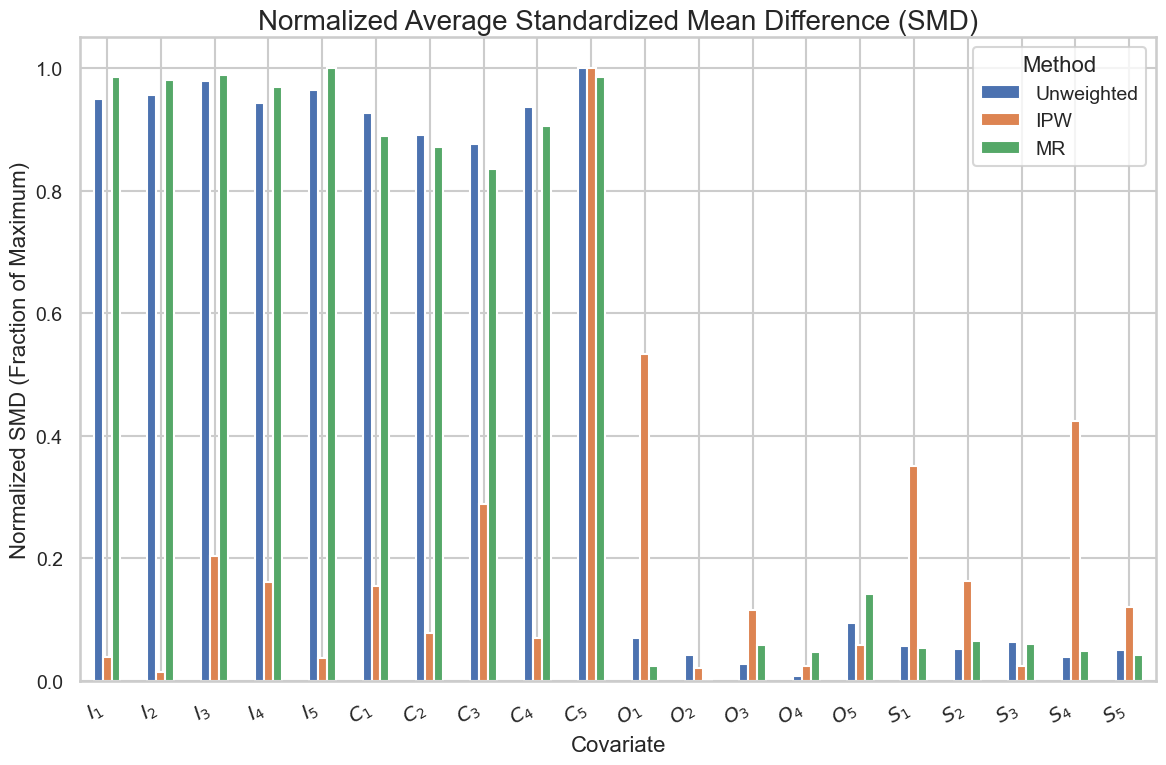

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Rename columns ---
smd_avg_renamed = smd_avg.rename(columns={
    'unweighted': 'Unweighted',
    'original_weights': 'IPW',
    'tilde_w': 'MR'
})

# --- Step 2: Standardize each column by dividing by its maximum value ---
smd_std = smd_avg_renamed.apply(lambda col: col / col.max(), axis=0)

# --- Step 3: Replace the x-axis labels in LaTeX math mode ---
# Create new labels in LaTeX math mode:
new_labels = [r"$I_{%d}$" % i for i in range(1, 6)] + \
             [r"$C_{%d}$" % i for i in range(1, 6)] + \
             [r"$O_{%d}$" % i for i in range(1, 6)] + \
             [r"$S_{%d}$" % i for i in range(1, 6)]
smd_std.index = new_labels

# --- Step 4: Plotting with enhanced aesthetics ---
sns.set(style="whitegrid", context="talk")
# Choose a custom color palette with as many colors as there are methods (columns)
colors = sns.color_palette('deep', n_colors=smd_std.shape[1])

ax = smd_std.plot(kind="bar", figsize=(12, 8), color=colors, 
                  edgecolor="white", linewidth=1.5)

plt.title('Normalized Average Standardized Mean Difference (SMD)', fontsize=20)
plt.xlabel('Covariate', fontsize=16)
plt.ylabel('Normalized SMD (Fraction of Maximum)', fontsize=16)
plt.xticks(rotation=30, ha="right", fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title="Method", fontsize=14, title_fontsize=16, loc="best")

plt.tight_layout()
plt.show()



In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Define helper functions ---
def weighted_variance(x, w):
    """
    Compute the weighted variance of an array x with weights w.
    """
    avg = np.average(x, weights=w)
    return np.average((x - avg)**2, weights=w)

def compute_smd(treated, control, weights_treated=None, weights_control=None):
    """
    Compute the Standardized Mean Difference (SMD) between two groups.
    
    Parameters:
      treated: array-like, covariate values for the treated group.
      control: array-like, covariate values for the control group.
      weights_treated: array-like, weights for the treated group (default: None).
      weights_control: array-like, weights for the control group (default: None).
    
    Returns:
      The absolute standardized mean difference.
    """
    # Compute means (weighted if weights are provided)
    if weights_treated is not None:
        treated_mean = np.average(treated, weights=weights_treated)
    else:
        treated_mean = np.mean(treated)
    
    if weights_control is not None:
        control_mean = np.average(control, weights=weights_control)
    else:
        control_mean = np.mean(control)
    
    # Compute variances using the original (unweighted) covariate values
    var_treated = np.var(treated, ddof=1)
    var_control = np.var(control, ddof=1)
    
    # Pooled variance and SMD calculation
    # pooled_var = (var_treated + var_control) / 2
    # return abs(treated_mean - control_mean) / np.sqrt(pooled_var)
    return abs(treated_mean - control_mean) 


# --- Set simulation parameters ---
n_iterations = 100  # number of iterations (change as desired)
n = 100             # sample size for each simulation
p = 20              # total number of covariates (assumed to be named X1, X2, ..., X20)
true_ate = 0         # true average treatment effect (ATE)

# --- Prepare a list to store the SMD DataFrame from each iteration ---
smd_list = []

# --- Loop over iterations ---
for seed in tqdm(range(n_iterations)):
    # Set the random seed so that each iteration uses a different seed.
    np.random.seed(seed)
    
    # Generate the simulated data (make sure your simulation function uses np.random)
    df = generate_data_causl(n=n, nI=5, nX=5, nO=5, nS=5, 
                                        ate=0, beta_cov=0, strength_instr=1, strength_conf=1, strength_outcome=1)
    
    # Extract the covariate columns (assumes they are named X1, X2, ..., X20)
    X = df[[f'X{i+1}' for i in range(p)]]
    A = df['A']
    
    # Run your estimation/trial function.
    # (If you wish the estimation procedure to also vary with seed, you might consider replacing 42 with `seed`.)
    ates, stds, df_est = single_trial(
        true_ate=true_ate, df_full=df, p=p,
        ps_model='original', or_model='original',
        w_model='lr',
        random_seed=42, cross_fit=True, n_folds=5,
        stds_return=True, coverage_return=False
    )
    
    # --- Compute weights ---
    # Original weights (computed as in your code)
    pi = df['hat_propen']  # assumed to exist in df
    original_weights = np.where(A == 1, 1 / pi, -1 / (1 - pi))
    
    # Assume tilde_w is available (uncomment the next line if you need to process it)
    tilde_w = df['hat_tilde_w']
    
    # --- Split data into treated and control groups ---
    treated = df[df['A'] == 1]
    control = df[df['A'] == 0]
    
    # Get positional indices so that we can match weights to the rows in X.
    treated_pos = X.index.get_indexer(treated.index)
    control_pos = X.index.get_indexer(control.index)
    
    # --- Compute SMDs for each covariate for each weighting method ---
    smd_iter = {}
    for covariate in X.columns:
        smd_iter[covariate] = {
            'unweighted': np.abs(np.mean(df['A']*df[covariate]-(1-df['A'])*df[covariate])),
            'original_weights': np.abs(np.mean(original_weights*df[covariate])),
            'tilde_w': np.abs(np.mean(df['hat_tilde_w']*df[covariate]))
        }


    # Convert the dictionary for this iteration into a DataFrame (rows: covariates; columns: weighting methods)
    smd_df_iter = pd.DataFrame(smd_iter).T
    smd_list.append(smd_df_iter)

# --- Compute the average SMD over iterations ---
# This adds up all the DataFrames and divides by the number of iterations.


100%|██████████| 100/100 [00:05<00:00, 17.40it/s]


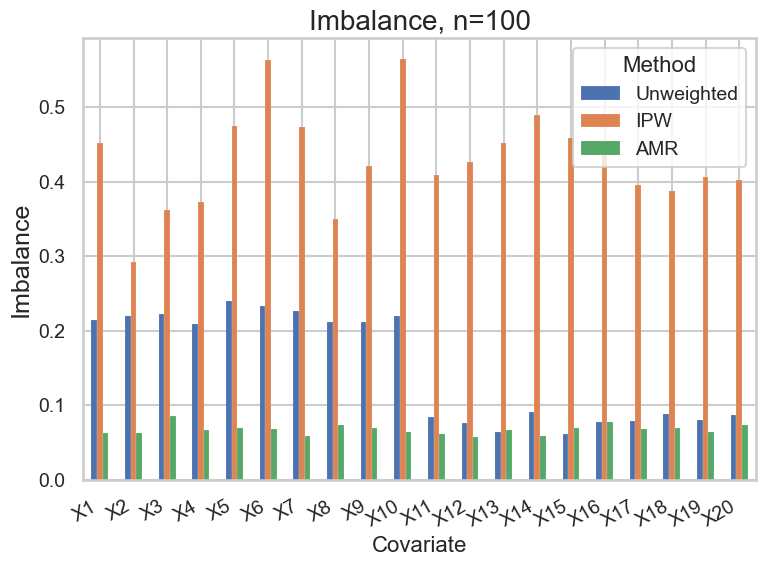

In [29]:
smd_avg = sum(smd_list) / len(smd_list)
smd_avg.rename(columns={
    'unweighted': 'Unweighted',
    'original_weights': 'IPW',
    'tilde_w': 'AMR'
}, inplace=True)


# new_labels = [r"$I_{%d}$" % i for i in range(1, 6)] + \
#              [r"$C_{%d}$" % i for i in range(1, 6)] + \
#              [r"$O_{%d}$" % i for i in range(1, 6)] + \
#              [r"$S_{%d}$" % i for i in range(1, 6)]
# smd_avg.index = new_labels

# --- Step 4: Plotting with enhanced aesthetics ---
sns.set(style="whitegrid", context="talk")
# Choose a custom color palette with as many colors as there are methods (columns)
colors = sns.color_palette('deep', n_colors=smd_std.shape[1])

ax = smd_avg.plot(kind="bar", figsize=(8, 6), color=colors, 
                  edgecolor="white", linewidth=0.1)

plt.title(f'Imbalance, n={n}', fontsize=20)
plt.xlabel('Covariate', fontsize=16)
plt.ylabel('Imbalance')
plt.xticks(rotation=30, ha="right", fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title="Method", fontsize=14, title_fontsize=16, loc="best")

plt.tight_layout()
plt.show()


100%|██████████| 20/20 [07:58<00:00, 23.92s/it]


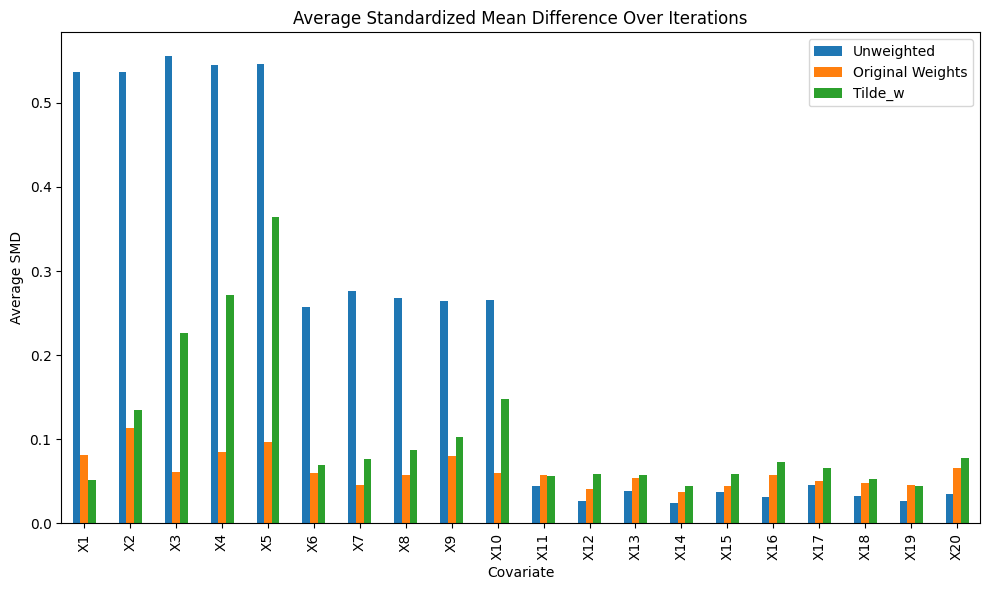

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Define helper functions ---
def weighted_variance(x, w):
    """
    Compute the weighted variance of an array x with weights w.
    """
    avg = np.average(x, weights=w)
    return np.average((x - avg)**2, weights=w)

def compute_smd(treated, control, weights_treated=None, weights_control=None, use_weighted_var=True):
    """
    Compute the Standardized Mean Difference (SMD) between two groups.
    
    Parameters:
      treated: array-like, covariate values for the treated group.
      control: array-like, covariate values for the control group.
      weights_treated: array-like, weights for the treated group (default: None).
      weights_control: array-like, weights for the control group (default: None).
      use_weighted_var: bool, if True then compute weighted variances if weights are given.
    
    Returns:
      The absolute standardized mean difference.
    """
    # Compute means and variances (weighted if weights are provided)
    if weights_treated is not None:
        treated_mean = np.average(treated, weights=weights_treated)
        var_treated = weighted_variance(treated, weights_treated) if use_weighted_var else np.var(treated, ddof=1)
    else:
        treated_mean = np.mean(treated)
        var_treated = np.var(treated, ddof=1)
    
    if weights_control is not None:
        control_mean = np.average(control, weights=weights_control)
        var_control = weighted_variance(control, weights_control) if use_weighted_var else np.var(control, ddof=1)
    else:
        control_mean = np.mean(control)
        var_control = np.var(control, ddof=1)
    
    # Pooled variance and SMD calculation
    pooled_var = (var_treated + var_control) / 2
    return abs(treated_mean - control_mean) / np.sqrt(pooled_var)

# --- Set simulation parameters ---
n_iterations = 20   # number of iterations (change as desired)
n = 2000             # sample size for each simulation
p = 20               # total number of covariates (assumed to be named X1, X2, ..., X20)
true_ate = 5         # true average treatment effect (ATE)

# --- Prepare a list to store the SMD DataFrame from each iteration ---
smd_list = []

# --- Loop over iterations ---
for seed in tqdm(range(n_iterations)):
    # Set the random seed so that each iteration uses a different seed.
    np.random.seed(seed)
    
    # Generate the simulated data (make sure your simulation function uses np.random)
    df = generate_data_causl(n=n, nI=5, nX=5, nO=5, nS=5, 
                                        ate=5, beta_cov=0, strength_instr=1, strength_conf=0.5, strength_outcome=1)
    
    # Extract the covariate columns (assumes they are named X1, X2, ..., X20)
    X = df[[f'X{i+1}' for i in range(p)]]
    A = df['A']
    
    # Run your estimation/trial function.
    # (If you wish the estimation procedure to also vary with seed, you might consider replacing 42 with `seed`.)
    ates, stds, df_est = single_trial(
        true_ate=true_ate, df_full=df, p=p,
        ps_model='lr', or_model='lr',
        w_model='kernel_ridge_regression',
        random_seed=42, cross_fit=True, n_folds=5,
        stds_return=True, coverage_return=False
    )
    
    # --- Compute weights ---
    # Original weights (computed as in your code)
    pi = df['hat_propen']  # assumed to exist in df
    original_weights = np.where(A == 1, (A - pi) / (pi * (1 - pi)), -((A - pi) / (pi * (1 - pi))))
    
    # Assume tilde_w is available (uncomment the next line if you need to process it)
    tilde_w = df['hat_tilde_w']
    
    # --- Split data into treated and control groups ---
    treated = df[df['A'] == 1]
    control = df[df['A'] == 0]
    
    # Get positional indices so that we can match weights to the rows in X.
    treated_pos = X.index.get_indexer(treated.index)
    control_pos = X.index.get_indexer(control.index)
    
    # --- Compute SMDs for each covariate for each weighting method ---
    smd_iter = {}
    for covariate in X.columns:
        smd_iter[covariate] = {
            'unweighted': compute_smd(treated[covariate], control[covariate]),
            'original_weights': compute_smd(
                treated[covariate],
                control[covariate],
                weights_treated=original_weights[treated_pos],
                weights_control=original_weights[control_pos]
            ),
            'tilde_w': compute_smd(
                treated[covariate],
                control[covariate],
                # Here we use the weights stored in df['hat_w1'] for the treated group and df['hat_w0'] for the control group.
                weights_treated=df['hat_w1'].iloc[treated_pos],
                weights_control=df['hat_w0'].iloc[control_pos]
            )
        }
    
    # Convert the dictionary for this iteration into a DataFrame (rows: covariates; columns: weighting methods)
    smd_df_iter = pd.DataFrame(smd_iter).T
    smd_list.append(smd_df_iter)

# --- Compute the average SMD over iterations ---
# This adds up all the DataFrames and divides by the number of iterations.
smd_avg = sum(smd_list) / len(smd_list)

# --- Plot the average SMD ---
ax = smd_avg.plot(kind='bar', figsize=(10, 6),)
plt.title('Average Standardized Mean Difference Over Iterations')
plt.xlabel('Covariate')
plt.ylabel('Average SMD')
plt.legend(['Unweighted', 'Original Weights', 'Tilde_w'])
plt.tight_layout()
plt.show()
